In [1]:
## 20160430 update
## 11/15/15: modify to use only 2009-12-31 data for roc curves and optimal cut-off graphs
## roc curves for 2009-2014 data
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta  ## use this to increment targ by 1 year!!!!
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
#import random

import sys
import os
os.chdir('C:/BankRisk')

In [2]:
## def(td,ff,px): # where td is dataframe, ff & px are column names of failflag and probdefault
def auc(td,ff,px):
  pn = td[td[ff]==0][[px,ff]]
  py = td[td[ff]==1][[px,ff]]
  pn.reset_index(drop=True, inplace=True)
  py.reset_index(drop=True, inplace=True)

  ln = len(pn)  # number of elements in non-failed list
  ly = len(py)   # number of elements in failed list
  cs = 0  # count successes

  for j in np.arange(ly):
    x = ( pn[px] < py.ix[j][px] )*1
    cs = cs + sum(x)

  r = float(cs) / float(ln * ly)  # area under curve
  return r  ## .982024 in excel

In [3]:
## make ctlst (cutlist) of 73 points spaced for good charts:
ctlst2 = list(np.arange(0,2,.1)) + list(np.arange(2,5,.5)) + list(np.arange(5,15,1)) + list(np.arange(15,90,5))
ctlst2 = ctlst2 + list(np.arange(90,97,1)) + list(np.arange(97,99,.5)) + list(np.arange(99,100,.1)) + [100]
#ctlst = [np.round(x,1) for x in ctlst]
ctlst = [np.round(float(x)/100,3) for x in ctlst2]
ctlst[15:25]

[0.014999999999999999,
 0.016,
 0.017000000000000001,
 0.017999999999999999,
 0.019,
 0.02,
 0.025000000000000001,
 0.029999999999999999,
 0.035000000000000003,
 0.040000000000000001]

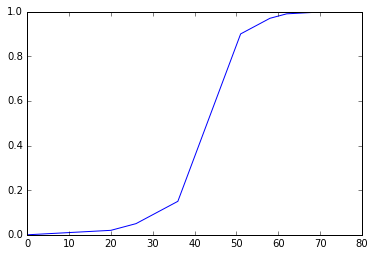

In [4]:
plt.plot(np.arange(len(ctlst)),ctlst)

In [6]:
## function for roc points (ctlst: 73 cuts) (1.1 sec to solve):
def roc(td,ff,px,ct):
  pn = td[td[ff]==0][[px,ff]]
  py = td[td[ff]==1][[px,ff]]

  ln = len(pn)  # number of elements in non-failed list
  ly = len(py)   # number of elements in failed list

  xm = pd.DataFrame(columns=['cut','fail', 'surv', 'sens', 'spec', 'FPR'],dtype='float')

  for i in np.arange(len(ct)):
    x1 = ct[i]
    x2 = sum((py[px] > x1)*1)
    x3 = sum((pn[px] > x1)*1)
    x4 = float(x2)/float(ly)
    x5 = float(ln - x3)/float(ln)
    x6 = 1 - x5
    xm=xm.append({'cut':x1,'fail':x2,'surv':x3,'sens':x4,'spec':x5,'FPR':x6},ignore_index=True)

  return xm

In [7]:
### read in all bank data with ratios to run ROC analyses:
dff = pd.read_csv("allbanks_f2468_roe0mm2_20091231.csv",index_col=0)
dff['AsOf'] = pd.to_datetime(dff['AsOf'])
dff['FailDate'] = pd.to_datetime(dff['FailDate'])
dff.head()

IDRSSD       AsOf                    Name State  eTotAst   rcTotLn  \
0      37 2001-12-31  BANK OF HANCOCK COUNTY    GA  66624.0  0.320412   
1      37 2002-03-31  BANK OF HANCOCK COUNTY    GA  68766.0  0.261846   
2      37 2002-06-30  BANK OF HANCOCK COUNTY    GA  69304.0  0.364757   
3      37 2002-09-30  BANK OF HANCOCK COUNTY    GA  71970.0  0.495989   
4      37 2002-12-31  BANK OF HANCOCK COUNTY    GA  74327.0  0.610962   

    qnTotLn      rNIM     rPPNR      rROA    ...     f4  f6  f8  Intercept  \
0  0.202341  4.771308  2.035791  1.366385    ...      0   0   0        1.0   
1  0.199812  4.673793  1.952308  1.314604    ...      0   0   0        1.0   
2  0.206747  4.599485  1.927457  1.294383    ...      0   0   0        1.0   
3  0.325492  4.492631  1.833764  1.235163    ...      0   0   0        1.0   
4  0.268236  4.436347  1.816232  1.214158    ...      0   0   0        1.0   

           f2_0          f2_1          f4_2          f4_3          f6_4  \
0  1.815612e-08  2.456293e-08  2.654284e-07  1.764341e-08  3.580763e-07   
1  2.072589e-08  2.817566e-08  2.979165e-07  2.060490e-08  4.061476e-07   
2  2.623083e-08  3.536649e-08  3.650533e-07  2.685621e-08  5.024802e-07   
3  4.453468e-08  5.935267e-08  5.789278e-07  4.896556e-08  8.189227e-07   
4  1.604883e-08  2.268381e-08  2.406663e-07  1.580418e-08  3.311848e-07   

       f6_5  
0  0.000002  
1  0.000002  
2  0.000003  
3  0.000004  
4  0.000002  

[5 rows x 33 columns]

In [8]:
dff['AsOf'].min(),dff['AsOf'].max()

(Timestamp('2001-12-31 00:00:00'), Timestamp('2014-12-31 00:00:00'))

In [9]:
prm0 = pd.read_csv("f246_params_roe0mm2_2009.csv",index_col=0)
#prm225 = pd.read_csv("f246_params_alt225mm_2009.csv",index_col=0)

In [10]:
prm0

idx  fx     v1        r1       v2        r2         v3        r3  \
0  0.0  f2  eT1rb  0.522181     rROE  0.572500    qnTotLn  0.595650   
1  0.0  f2  eT1rb  0.522181     rROE  0.572500    qnTotLn  0.595650   
2  3.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROE  0.517801   
3  2.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROA  0.520142   
4  4.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   
5  4.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   

          v4        r4       Int        c1        c2        c3        c4  
0  eBrok_Dep  0.611861 -2.799513 -0.473053 -0.024954  0.084635  0.034710  
1   lnTotAst  0.605720 -6.621654 -0.450486 -0.028629  0.084572  0.310082  
2  eBrok_Dep  0.544656 -2.201036 -0.406007  0.112216 -0.028424  0.041344  
3  eBrok_Dep  0.543210 -0.956072 -0.525634  0.116850 -0.306411  0.038855  
4       rROA  0.460012 -1.300542 -0.419816  0.145885  0.042008 -0.286718  
5       rROE  0.458435 -2.075058 -0.346648  0.140151  0.043325 -0.025627

In [11]:
xcol=['rcTotLn','qnTotLn','rNIM','rPPNR','rROA','rROE','rEff','eLn_Dep','aFF_TA','eBrok_Dep','eT1rb','eTotrb','eALLL_Ln','lnTotAst']
xcol

['rcTotLn',
 'qnTotLn',
 'rNIM',
 'rPPNR',
 'rROA',
 'rROE',
 'rEff',
 'eLn_Dep',
 'aFF_TA',
 'eBrok_Dep',
 'eT1rb',
 'eTotrb',
 'eALLL_Ln',
 'lnTotAst']

In [12]:
fcol = [x for x in list(dff.columns) if x[0:1]=='f']
fcol

['f2', 'f4', 'f6', 'f8', 'f2_0', 'f2_1', 'f4_2', 'f4_3', 'f6_4', 'f6_5']

In [13]:
targ = pd.to_datetime('2009-12-31')
thresh = 0 ## no minimum size threshold (not needed)
alt = '' ## or alt = ''
dfh = dff[(dff['AsOf']<=targ)&(dff['eTotAst']>(thresh*1000))]\
      [['IDRSSD','AsOf','Name','FailDate']+xcol+fcol]
#dfr09 = sm.add_constant(dfr09)
len(dfh), len(dff)

(259210, 395257)

In [14]:
dfh[xcol].max()

rcTotLn      3.543633e+03
qnTotLn      1.000000e+02
rNIM         4.160000e+04
rPPNR        5.272914e+02
rROA         3.423426e+02
rROE         5.877828e+02
rEff         5.480120e+07
eLn_Dep      9.934150e+02
aFF_TA       1.534201e+02
eBrok_Dep    1.000000e+02
eT1rb        1.999829e+02
eTotrb       2.268312e+02
eALLL_Ln     1.000000e+02
lnTotAst     2.129349e+01
dtype: float64

In [15]:
dfh[xcol].min()

rcTotLn     -5.000000e-01
qnTotLn      0.000000e+00
rNIM        -1.360000e+04
rPPNR       -6.429146e+01
rROA        -7.697304e+01
rROE        -1.998472e+02
rEff        -3.359000e+08
eLn_Dep      0.000000e+00
aFF_TA      -2.722560e+02
eBrok_Dep    0.000000e+00
eT1rb        0.000000e+00
eTotrb       0.000000e+00
eALLL_Ln     0.000000e+00
lnTotAst     6.486161e+00
dtype: float64

In [16]:
## screening criteria:
dfh.dropna(how='any',inplace=True,subset=dfh.columns[8:])  # delete any ratio columns with NaN values (note columns[8:])
dfh= dfh[dfh['eLn_Dep']<=1000]
dfh= dfh[dfh['eBrok_Dep']<=100]
dfh= dfh[dfh['eALLL_Ln']<=100]
dfh= dfh[dfh['rROE']>=-200]
dfh= dfh[dfh['lnTotAst']>2]
dfh= dfh[dfh['eT1rb']<=200]
len(dfh)

259210

In [17]:
## set fflags to zero if FailDate after targ2 date (12/31/2010); that is, for f4
## increment date by interval:
targ2 = pd.to_datetime((targ.year+1)*10000 + targ.month*100 + targ.day, format='%Y%m%d')  # handles leap years
dfh.ix[dfh.FailDate>targ2,['f2','f4','f6','f8']] = [0,0,0,0]
targ2

Timestamp('2010-12-31 00:00:00')

In [18]:
dfh.ix[(dfh.FailDate>'2010-09-01')&(dfh.FailDate<'2011-03-01')&(dfh.AsOf>'2009-09-01'),\
       ['IDRSSD','AsOf','Name','FailDate','f2','f4','f6','f8']].head(8)

IDRSSD       AsOf                   Name   FailDate  f2  f4  f6  f8
4658    16337 2009-09-30           WAKULLA BANK 2010-10-01   0   0   1   1
4659    16337 2009-12-31           WAKULLA BANK 2010-10-01   0   1   1   1
12588   41647 2009-09-30   FIRST BANKING CENTER 2010-11-19   0   0   1   1
12589   41647 2009-12-31   FIRST BANKING CENTER 2010-11-19   0   1   1   1
16806   54357 2009-09-30  FIRST STATE BANK, THE 2011-01-28   0   0   0   0
16807   54357 2009-12-31  FIRST STATE BANK, THE 2011-01-28   0   0   0   0
36428  117841 2009-09-30   EVERGREEN STATE BANK 2011-01-28   0   0   0   0
36429  117841 2009-12-31   EVERGREEN STATE BANK 2011-01-28   0   0   0   0

In [19]:
dfh.ix[(dfh.FailDate>'2010-09-01')&(dfh.FailDate<'2012-01-01')&(dfh.AsOf>'2009-09-01'),\
       ['IDRSSD','AsOf','Name','FailDate','f2','f4','f6','f8']].head()

IDRSSD       AsOf                 Name   FailDate  f2  f4  f6  f8
4658   16337 2009-09-30         WAKULLA BANK 2010-10-01   0   0   1   1
4659   16337 2009-12-31         WAKULLA BANK 2010-10-01   0   1   1   1
6017   20370 2009-09-30  FIRST HERITAGE BANK 2011-05-27   0   0   0   0
6018   20370 2009-12-31  FIRST HERITAGE BANK 2011-05-27   0   0   0   0
7011   23241 2009-09-30      INTEGRA BANK NA 2011-07-29   0   0   0   0

In [20]:
dff.columns

Index([u'IDRSSD', u'AsOf', u'Name', u'State', u'eTotAst', u'rcTotLn',
       u'qnTotLn', u'rNIM', u'rPPNR', u'rROA', u'rROE', u'rEff', u'eLn_Dep',
       u'aFF_TA', u'eBrok_Dep', u'eT1rb', u'eTotrb', u'eALLL_Ln', u'lnTotAst',
       u'FailDate', u'mtf', u'mtf2', u'f2', u'f4', u'f6', u'f8', u'Intercept',
       u'f2_0', u'f2_1', u'f4_2', u'f4_3', u'f6_4', u'f6_5'],
      dtype='object')

In [21]:
dfh.columns

Index([u'IDRSSD', u'AsOf', u'Name', u'FailDate', u'rcTotLn', u'qnTotLn',
       u'rNIM', u'rPPNR', u'rROA', u'rROE', u'rEff', u'eLn_Dep', u'aFF_TA',
       u'eBrok_Dep', u'eT1rb', u'eTotrb', u'eALLL_Ln', u'lnTotAst', u'f2',
       u'f4', u'f6', u'f8', u'f2_0', u'f2_1', u'f4_2', u'f4_3', u'f6_4',
       u'f6_5'],
      dtype='object')

In [22]:
### generate forecasts for all 4-var models:
dv4 = pd.DataFrame(columns=['idx','fx','v1', 'r1', 'v2', 'r2','v3', 'r3','v4','r4'])
cv4 = pd.DataFrame(columns=['idx','v4','Int','c1','c2','c3','c4'])

for idx, row in prm0.iterrows():
  fv = row['fx']
  x = idx
  eqnc = fv + " ~ " + " + ".join(row[['v1', 'v2', 'v3','v4']])  # regression eqn
  pvar = ["Intercept", row['v1'], row['v2'], row['v3'], row['v4']]  # vars for predictions
  yc, Xc = dmatrices(eqnc , data=dfh, return_type='dataframe')
  res = sm.Logit(yc, Xc).fit()
  dv4 = dv4.append({'idx':idx,'fx':row['fx'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],'r2':row['r2'],\
                    'v3':row['v3'],'r3': row['r3'], 'v4':row['v4'],'r4': res.prsquared},ignore_index=True)
  cm = pd.DataFrame(res.params).T
  cm.columns = ['Int','c1','c2','c3','c4']
  cm['idx'] = idx
  cm['v4'] = row['v4']
  cv4 = cv4.append(cm.ix[0])
  pred_tot = res.predict(Xc)
  dfh[fv+'_'+str(x)+'rr'] = pred_tot
  p_tot = res.predict(dff[pvar])  # forecasts  dff: future vars
  dff[fv+'_'+str(x)+'rr'] = p_tot

cv4 = cv4.reset_index(drop=True)
dv4 = dv4.reset_index(drop=True)
dv4 = dv4.merge(cv4, how='inner', on=['idx','v4'])


Optimization terminated successfully.
         Current function value: 0.004026
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004090
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.010472
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.010505
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.018775
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.018829
         Iterations 12


In [23]:
dv4

idx  fx     v1        r1       v2        r2         v3        r3  \
0  0.0  f2  eT1rb  0.522181     rROE  0.572500    qnTotLn  0.595650   
1  1.0  f2  eT1rb  0.522181     rROE  0.572500    qnTotLn  0.595650   
2  2.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROE  0.517801   
3  3.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROA  0.520142   
4  4.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   
5  5.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   

          v4        r4       Int        c1        c2        c3        c4  
0  eBrok_Dep  0.611861 -2.799513 -0.473053 -0.024954  0.084635  0.034710  
1   lnTotAst  0.605720 -6.621654 -0.450486 -0.028629  0.084572  0.310082  
2  eBrok_Dep  0.544656 -2.201036 -0.406007  0.112216 -0.028424  0.041344  
3  eBrok_Dep  0.543210 -0.956072 -0.525634  0.116850 -0.306411  0.038855  
4       rROA  0.460012 -1.300542 -0.419816  0.145885  0.042008 -0.286718  
5       rROE  0.458435 -2.075058 -0.346648  0.140151  0.043325 -0.025627

In [24]:
prm0

idx  fx     v1        r1       v2        r2         v3        r3  \
0  0.0  f2  eT1rb  0.522181     rROE  0.572500    qnTotLn  0.595650   
1  0.0  f2  eT1rb  0.522181     rROE  0.572500    qnTotLn  0.595650   
2  3.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROE  0.517801   
3  2.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROA  0.520142   
4  4.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   
5  4.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   

          v4        r4       Int        c1        c2        c3        c4  
0  eBrok_Dep  0.611861 -2.799513 -0.473053 -0.024954  0.084635  0.034710  
1   lnTotAst  0.605720 -6.621654 -0.450486 -0.028629  0.084572  0.310082  
2  eBrok_Dep  0.544656 -2.201036 -0.406007  0.112216 -0.028424  0.041344  
3  eBrok_Dep  0.543210 -0.956072 -0.525634  0.116850 -0.306411  0.038855  
4       rROA  0.460012 -1.300542 -0.419816  0.145885  0.042008 -0.286718  
5       rROE  0.458435 -2.075058 -0.346648  0.140151  0.043325 -0.025627

In [25]:
dv4.to_csv("modelrerun_f246_params_roe0mm2_2009.csv")

In [26]:
fcolrr = [x for x in list(dff.columns) if x[0:1]=='f']
fcolrr

['f2',
 'f4',
 'f6',
 'f8',
 'f2_0',
 'f2_1',
 'f4_2',
 'f4_3',
 'f6_4',
 'f6_5',
 'f2_0rr',
 'f2_1rr',
 'f4_2rr',
 'f4_3rr',
 'f6_4rr',
 'f6_5rr']

In [27]:
dffsum=dff[['AsOf']+fcolrr].groupby('AsOf').sum()
dffsum.ix['2009':'2010']

f2   f4   f6   f8       f2_0       f2_1        f4_2        f4_3  \
AsOf                                                                          
2009-03-31  55  127  197  248  39.918062  38.468210   91.285071   92.507745   
2009-06-30  59  131  189  232  49.092300  50.076222  109.048639  106.968949   
2009-09-30  52  119  170  213  48.978526  50.294342  113.130375  109.504340   
2009-12-31  62  120  163  204  73.303119  74.859618  150.568615  146.838819   
2010-03-31  53  104  146  177  70.683851  74.627545  140.231834  127.024879   
2010-06-30  43   86  127  151  58.258145  63.955326  117.356746  101.372738   
2010-09-30  36   78  108  127  52.635865  58.345715  105.976520   88.207975   
2010-12-31  34   75   99  115  52.011837  56.621819  105.626994   94.541408   

                  f6_4        f6_5     f2_0rr     f2_1rr      f4_2rr  \
AsOf                                                                   
2009-03-31  136.444662  133.973590  39.918062  38.468210   91.285071   
2009-06-30  154.646575  155.622310  49.092300  50.076222  109.048639   
2009-09-30  161.100308  164.032655  48.978526  50.294342  113.130375   
2009-12-31  197.041137  201.210397  73.303119  74.859618  150.568615   
2010-03-31  172.376513  185.320011  70.683851  74.627545  140.231834   
2010-06-30  142.504080  158.591152  58.258145  63.955326  117.356746   
2010-09-30  125.223577  144.154169  52.635865  58.345715  105.976520   
2010-12-31  129.620304  142.705195  52.011837  56.621819  105.626994   

                f4_3rr      f6_4rr      f6_5rr  
AsOf                                            
2009-03-31   92.507745  136.444662  133.973590  
2009-06-30  106.968949  154.646575  155.622310  
2009-09-30  109.504340  161.100308  164.032655  
2009-12-31  146.838819  197.041137  201.210397  
2010-03-31  127.024879  172.376513  185.320011  
2010-06-30  101.372738  142.504080  158.591152  
2010-09-30   88.207975  125.223577  144.154169  
2010-12-31   94.541408  129.620304  142.705195

In [28]:
## single variable models for all fx:
dvv = pd.DataFrame(columns=['fx','v1', 'r1'])
cvv = pd.DataFrame(columns=['fx','v1','Int','c1'])

vr=prm0[['v1','v2','v3','v4']].values
vrlst = list(set(e for r in vr for e in r))  ## list of unique variables among coefficients
vrlst = vrlst + ['eLn_Dep','aFF_TA']

for x in vrlst:
  for y in ['f2','f4','f6']:
    eqnc = y + " ~ " + x  # regression eqn
    pvar = ["Intercept", x]  # var for predictions
    yc, Xc = dmatrices(eqnc , data=dfh, return_type='dataframe')
    res = sm.Logit(yc, Xc).fit()
    dvv = dvv.append({'fx':y,'v1':x,'r1':res.prsquared},ignore_index=True)
    cm = pd.DataFrame(res.params).T
    cm.columns = ['Int','c1']
    cm['fx'] = y
    cm['v1'] = x
    cvv = cvv.append(cm)
    pred_tot = res.predict(Xc)
    dfh[y+'_'+x] = pred_tot
    p_tot = res.predict(dff[pvar])  # forecasts  dff: future vars
    dff[y+'_'+x] = p_tot

cvv = cvv.reset_index(drop=True)
dvv = dvv.reset_index(drop=True)
dvv = dvv.merge(cvv, how='inner', on=['fx','v1'])

Optimization terminated successfully.
         Current function value: 0.010080
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.022299
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.033651
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.005303
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.013873
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.024339
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.008952
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.019656
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.030498
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.0

In [29]:
dvv

fx         v1        r1        Int        c1
0   f2   lnTotAst  0.028233 -11.176789  0.374696
1   f4   lnTotAst  0.030360 -10.167129  0.368479
2   f6   lnTotAst  0.032131  -9.661138  0.367514
3   f2       rROE  0.488795  -7.358052 -0.056345
4   f4       rROE  0.396744  -6.084051 -0.059825
5   f6       rROE  0.299965  -5.349211 -0.057429
6   f2       rROA  0.136966  -6.644176 -0.271631
7   f4       rROA  0.145298  -5.700188 -0.326827
8   f6       rROA  0.122823  -5.160596 -0.331130
9   f2      eT1rb  0.522181   2.809685 -0.969876
10  f4      eT1rb  0.399541   3.640299 -0.907987
11  f6      eT1rb  0.292186   2.943719 -0.757253
12  f2    qnTotLn  0.130563  -6.986268  0.164781
13  f4    qnTotLn  0.211410  -6.378276  0.272325
14  f6    qnTotLn  0.207348  -5.908558  0.297713
15  f2  eBrok_Dep  0.056154  -6.927195  0.041727
16  f4  eBrok_Dep  0.066877  -6.009661  0.042884
17  f6  eBrok_Dep  0.074322  -5.526108  0.043971
18  f2    eLn_Dep  0.001881  -6.884747  0.003556
19  f4    eLn_Dep  0.003798  -6.013038  0.004215
20  f6    eLn_Dep  0.006362  -5.573603  0.004813
21  f2     aFF_TA  0.002738  -6.700089  0.019721
22  f4     aFF_TA  0.000844  -5.720939  0.011124
23  f6     aFF_TA  0.000002  -5.171728 -0.000568

In [30]:
dvv.to_csv("SingleVar_params_roe0mm2_2009.csv")

In [31]:
dff.to_csv("allbanks_f2468_roe0mm2_20091231_singles.csv",index_col=0)
dfh.to_csv("modelbanks_f2468_roe0mm2_2009_singles.csv",index_col=0)

In [32]:
fcol = [x for x in list(dff.columns) if x[0]=='f']
fcol[10:26]

['f2_0rr',
 'f2_1rr',
 'f4_2rr',
 'f4_3rr',
 'f6_4rr',
 'f6_5rr',
 'f2_lnTotAst',
 'f4_lnTotAst',
 'f6_lnTotAst',
 'f2_rROE',
 'f4_rROE',
 'f6_rROE',
 'f2_rROA',
 'f4_rROA',
 'f6_rROA',
 'f2_eT1rb']

In [33]:
fnbr = dff[['AsOf']+fcol[0:5]+fcol[10:16]].groupby('AsOf').sum()
fnbr['2009':'2011']

f2   f4   f6   f8       f2_0     f2_0rr     f2_1rr      f4_2rr  \
AsOf                                                                         
2009-03-31  55  127  197  248  39.918062  39.918062  38.468210   91.285071   
2009-06-30  59  131  189  232  49.092300  49.092300  50.076222  109.048639   
2009-09-30  52  119  170  213  48.978526  48.978526  50.294342  113.130375   
2009-12-31  62  120  163  204  73.303119  73.303119  74.859618  150.568615   
2010-03-31  53  104  146  177  70.683851  70.683851  74.627545  140.231834   
2010-06-30  43   86  127  151  58.258145  58.258145  63.955326  117.356746   
2010-09-30  36   78  108  127  52.635865  52.635865  58.345715  105.976520   
2010-12-31  34   75   99  115  52.011837  52.011837  56.621819  105.626994   
2011-03-31  32   62   83   93  46.254542  46.254542  51.298543   93.503539   
2011-06-30  25   48   63   74  37.409513  37.409513  42.206487   79.031321   
2011-09-30  19   38   48   60  35.141000  35.141000  40.006978   72.357686   
2011-12-31  18   34   46   54  31.030340  31.030340  34.981022   64.148672   

                f4_3rr      f6_4rr      f6_5rr  
AsOf                                            
2009-03-31   92.507745  136.444662  133.973590  
2009-06-30  106.968949  154.646575  155.622310  
2009-09-30  109.504340  161.100308  164.032655  
2009-12-31  146.838819  197.041137  201.210397  
2010-03-31  127.024879  172.376513  185.320011  
2010-06-30  101.372738  142.504080  158.591152  
2010-09-30   88.207975  125.223577  144.154169  
2010-12-31   94.541408  129.620304  142.705195  
2011-03-31   79.352067  110.580152  126.059263  
2011-06-30   64.193686   92.269040  109.006570  
2011-09-30   58.128207   82.706066   98.799902  
2011-12-31   55.947444   78.236779   88.698890

In [34]:
###########################################################################################
# change this to 20091231 only!!!
###########################################################################################

dffg = dff[dff['AsOf']=='2009-12-31'][['AsOf']+fcol]

In [35]:
len(dffg)  ## was 2009-2014 165,272 rows...

7220

In [36]:
dffg.tail(2)

AsOf  f2  f4  f6  f8          f2_0          f2_1          f4_2  \
404544 2009-12-31   0   0   0   0  7.338898e-10  1.088939e-09  2.190482e-08   
404568 2009-12-31   0   0   0   0  6.212909e-07  8.110640e-07  6.146088e-06   

                f4_3          f6_4    ...      f6_qnTotLn  f2_eBrok_Dep  \
404544  1.884868e-08  7.105124e-07    ...        0.002709       0.00098   
404568  2.069154e-06  1.905622e-05    ...        0.002709       0.00098   

        f4_eBrok_Dep  f6_eBrok_Dep  f2_eLn_Dep  f4_eLn_Dep  f6_eLn_Dep  \
404544      0.002449      0.003966    0.001265    0.003141    0.005042   
404568      0.002449      0.003966    0.001300    0.003243    0.005229   

        f2_aFF_TA  f4_aFF_TA  f6_aFF_TA  
404544   0.001627   0.003824   0.005598  
404568   0.001521   0.003682   0.005608  

[2 rows x 41 columns]

In [37]:
dffg[['f4','f6']].groupby('f4').count()

f6
f4      
0   7100
1    120

In [38]:
dff[['f4','f6']].groupby('f4').count()

f6
f4        
0   393629
1     1628

In [39]:
%time xc = roc(dffg, 'f4', 'f4_2', ctlst)

Wall time: 228 ms


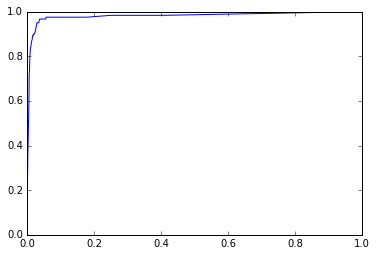

In [40]:
plt.plot(xc['FPR'],xc['sens'],c='b')

In [43]:
def auc(td,ff,px):
  pn = td[td[ff]==0][[px,ff]]
  pn.reset_index(drop=True, inplace=True)
  py = td[td[ff]==1][[px,ff]]
  py.reset_index(drop=True, inplace=True)

  ln = len(pn)  # number of elements in non-failed list
  ly = len(py)   # number of elements in failed list
  cs = 0  # count successes

  for j in np.arange(ly):
    x = ( pn[px] < py.ix[j][px] )*1
    cs = cs + sum(x)

  r = float(cs) / float(ln * ly)  # area under curve
  return r  ## .982024 in excel

%time x = auc(dffg, 'f4', 'f4_2rr')

Wall time: 163 ms


In [44]:
x

0.9788098591549296

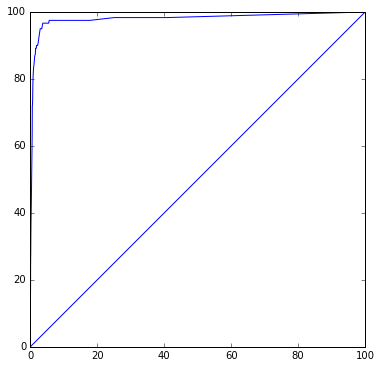

In [45]:
## Code to resize chart frame !!!!!!
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1, plSize[1]*1.5) )  ## double width, single height
plt.plot([0,100],[0,100])
plt.plot(xc['FPR']*100,xc['sens']*100,c='b')
plt.show()

In [46]:
f4lst0=[x for x in list(dffg.columns) if x[0:2]=='f4']  ## all f4 columns
f4lst= [x for x in f4lst0 if x not in ['f4','f4_2','f4_3','f4_aFF_TA']]  ## no f4; only vars used in models plus 2 dummy vars
f4lst

['f4_2rr',
 'f4_3rr',
 'f4_lnTotAst',
 'f4_rROE',
 'f4_rROA',
 'f4_eT1rb',
 'f4_qnTotLn',
 'f4_eBrok_Dep',
 'f4_eLn_Dep']

In [47]:
f4auc = pd.DataFrame(columns=['modvar','auc','aucs'])

for x in f4lst:
  y = auc(dffg, 'f4', x)
  f4auc=f4auc.append({'modvar':x,'auc':y, 'aucs': str(np.round(y*100,1))},ignore_index=True)
  print(x)

f4_2rr
f4_3rr
f4_lnTotAst
f4_rROE
f4_rROA
f4_eT1rb
f4_qnTotLn
f4_eBrok_Dep
f4_eLn_Dep


In [48]:
f4auc['aucs'] = f4auc.apply(lambda x: str(np.round(x['auc']*100,1)),axis=1)
f4auc

modvar       auc  aucs
0        f4_2rr  0.978810  97.9
1        f4_3rr  0.978256  97.8
2   f4_lnTotAst  0.640664  64.1
3       f4_rROE  0.972791  97.3
4       f4_rROA  0.953662  95.4
5      f4_eT1rb  0.972092  97.2
6    f4_qnTotLn  0.955862  95.6
7  f4_eBrok_Dep  0.751748  75.2
8    f4_eLn_Dep  0.549681  55.0

In [49]:
f4auc.to_csv("f4auc_roe0mm2_20091231exact.csv")

In [50]:
f6lst0=[x for x in list(dffg.columns) if x[0:2]=='f6']  ## all f4 columns
f6lst= [x for x in f6lst0 if x not in ['f6','f6_4','f6_5','f6_aFF_TA']] 
f6lst

['f6_4rr',
 'f6_5rr',
 'f6_lnTotAst',
 'f6_rROE',
 'f6_rROA',
 'f6_eT1rb',
 'f6_qnTotLn',
 'f6_eBrok_Dep',
 'f6_eLn_Dep']

In [51]:
f6auc = pd.DataFrame(columns=['modvar','auc','aucs'])

for x in f6lst:
  y = auc(dffg, 'f6', x)
  f6auc=f6auc.append({'modvar':x,'auc':y,'aucs': str(np.round(y*100,1))},ignore_index=True)
  print(x)

f6_4rr
f6_5rr
f6_lnTotAst
f6_rROE
f6_rROA
f6_eT1rb
f6_qnTotLn
f6_eBrok_Dep
f6_eLn_Dep


In [52]:
f2lst0=[x for x in list(dffg.columns) if x[0:2]=='f2']  ## all f4 columns
f2lst= [x for x in f2lst0 if x not in ['f2','f2_0','f2_1','f2_aFF_TA']] 
f2lst

['f2_0rr',
 'f2_1rr',
 'f2_lnTotAst',
 'f2_rROE',
 'f2_rROA',
 'f2_eT1rb',
 'f2_qnTotLn',
 'f2_eBrok_Dep',
 'f2_eLn_Dep']

In [53]:
f2auc = pd.DataFrame(columns=['modvar','auc','aucs'])

for x in f2lst:
  y = auc(dffg, 'f2', x)
  f2auc=f2auc.append({'modvar':x,'auc':y,'aucs': str(np.round(y*100,1))},ignore_index=True)
  print(x)

f2_0rr
f2_1rr
f2_lnTotAst
f2_rROE
f2_rROA
f2_eT1rb
f2_qnTotLn
f2_eBrok_Dep
f2_eLn_Dep


In [54]:
f2auc

modvar       auc  aucs
0        f2_0rr  0.970912  97.1
1        f2_1rr  0.970840  97.1
2   f2_lnTotAst  0.648787  64.9
3       f2_rROE  0.967810  96.8
4       f2_rROA  0.948936  94.9
5      f2_eT1rb  0.971597  97.2
6    f2_qnTotLn  0.945901  94.6
7  f2_eBrok_Dep  0.719146  71.9
8    f2_eLn_Dep  0.557173  55.7

In [55]:
f2auc.to_csv("f2auc_roe0mm2_20091231exact.csv")

In [56]:
f6auc.to_csv("f6auc_roe0mm2_20091231exact.csv")

In [57]:
f6auc

modvar       auc  aucs
0        f6_4rr  0.973779  97.4
1        f6_5rr  0.973932  97.4
2   f6_lnTotAst  0.636810  63.7
3       f6_rROE  0.958850  95.9
4       f6_rROA  0.941276  94.1
5      f6_eT1rb  0.964260  96.4
6    f6_qnTotLn  0.947341  94.7
7  f6_eBrok_Dep  0.738499  73.8
8    f6_eLn_Dep  0.561794  56.2

In [58]:
%time y = roc(dffg, 'f4', 'f4_2rr',ctlst)

Wall time: 233 ms


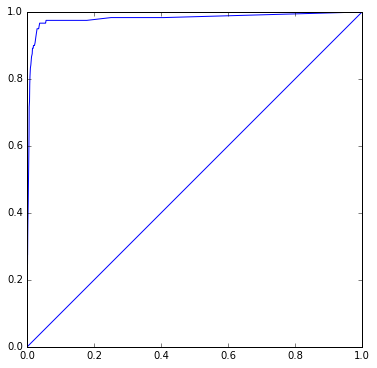

In [59]:
## Code to resize chart frame !!!!!!
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1, plSize[1]*1.5) )  ## double width, single height
plt.plot([0,1],[0,1])
plt.plot(y['FPR'],y['sens'],c='b')
plt.show()

In [60]:
#f4roc:
for i in np.arange(len(f4lst)):
#for i in np.arange(2):
  v = f4lst[i]
  y = roc(dffg, 'f4', v, ctlst)
  if i == 0:
    f4roc = y[['cut','sens','FPR']]
    f4roc.rename(columns={'FPR':v+'_FPR','sens':v+'_sens'},inplace=True)
  else:
    f4roc = f4roc.merge(y[['cut','sens','FPR']],how='left',on='cut')
    f4roc.rename(columns={'FPR':v+'_FPR','sens':v+'_sens'},inplace=True)

f4roc.to_csv("f4rocpts_roe0mm2_20091231exact.csv")
f4roc.head()    

cut  f4_2rr_sens  f4_2rr_FPR  f4_3rr_sens  f4_3rr_FPR  f4_lnTotAst_sens  \
0  0.000     1.000000    1.000000     1.000000    1.000000          1.000000   
1  0.001     0.983333    0.407887     0.983333    0.375775          1.000000   
2  0.002     0.983333    0.250423     0.975000    0.242676          0.958333   
3  0.003     0.975000    0.178028     0.975000    0.177606          0.691667   
4  0.004     0.975000    0.142676     0.975000    0.141549          0.441667   

   f4_lnTotAst_FPR  f4_rROE_sens  f4_rROE_FPR  f4_rROA_sens  f4_rROA_FPR  \
0         1.000000      1.000000     1.000000      1.000000     1.000000   
1         0.997606      0.991667     0.892394      1.000000     0.993944   
2         0.861268      0.983333     0.370423      0.991667     0.914507   
3         0.517606      0.975000     0.214225      0.983333     0.411408   
4         0.266901      0.975000     0.164648      0.975000     0.208028   

   f4_eT1rb_sens  f4_eT1rb_FPR  f4_qnTotLn_sens  f4_qnTotLn_FPR  \
0       1.000000      1.000000         1.000000        1.000000   
1       0.966667      0.344366         1.000000        1.000000   
2       0.966667      0.241690         0.983333        0.680282   
3       0.966667      0.184085         0.983333        0.374225   
4       0.966667      0.143239         0.975000        0.250563   

   f4_eBrok_Dep_sens  f4_eBrok_Dep_FPR  f4_eLn_Dep_sens  f4_eLn_Dep_FPR  
0           1.000000          1.000000         1.000000        1.000000  
1           1.000000          1.000000         1.000000        1.000000  
2           1.000000          1.000000         1.000000        1.000000  
3           0.691667          0.258028         0.991667        0.911972  
4           0.441667          0.133099         0.008333        0.016901

In [61]:
######### CAUTION ############################################
# shortcut to skip earlier processing and get to charts below
##############################################################

## read auc files:
#f2auc= pd.read_csv("f2auc_roe0mm2_20091231.csv",index_col=0)
#f4auc= pd.read_csv("f4auc_roe0mm2_20091231.csv",index_col=0)
#f6auc= pd.read_csv("f6auc_roe0mm2_20091231.csv",index_col=0)
#f2auc['aucs'] = f2auc['aucs'].astype(str)
#f4auc['aucs'] = f4auc['aucs'].astype(str)
#f6auc['aucs'] = f6auc['aucs'].astype(str)

## read roc files:
#f2roc= pd.read_csv("f2rocpts_roe0mm2_2009.csv",index_col=0)
#f4roc= pd.read_csv("f4rocpts_roe0mm2_2009.csv",index_col=0)
#f6roc= pd.read_csv("f6rocpts_roe0mm2_2009.csv",index_col=0)

In [62]:
f2auc.dtypes

modvar     object
auc       float64
aucs       object
dtype: object

In [63]:
f4roc.columns

Index([u'cut', u'f4_2rr_sens', u'f4_2rr_FPR', u'f4_3rr_sens', u'f4_3rr_FPR',
       u'f4_lnTotAst_sens', u'f4_lnTotAst_FPR', u'f4_rROE_sens',
       u'f4_rROE_FPR', u'f4_rROA_sens', u'f4_rROA_FPR', u'f4_eT1rb_sens',
       u'f4_eT1rb_FPR', u'f4_qnTotLn_sens', u'f4_qnTotLn_FPR',
       u'f4_eBrok_Dep_sens', u'f4_eBrok_Dep_FPR', u'f4_eLn_Dep_sens',
       u'f4_eLn_Dep_FPR'],
      dtype='object')

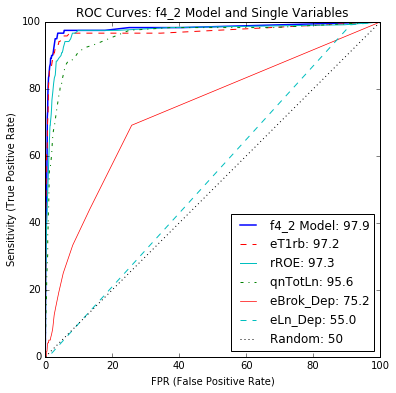

In [64]:
## Code to resize chart frame !!!!!!
#f4auc['aucs'] = f4auc.apply(lambda x:str(np.round(x['auc']*100,1)),axis=1)
dauc= dict(zip(f4auc['modvar'],f4auc['aucs']))

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1, plSize[1]*1.5) )  ## double width, single height
plt.plot(f4roc['f4_2rr_FPR']*100,f4roc['f4_2rr_sens']*100,c='b',lw=1.5,label='f4_2 Model: '+dauc['f4_2rr'])
#plt.plot(f4roc['f4_3rr_FPR'],f4roc['f4_3rr_sens'],c='b',ls='--',label='f4 Model2: '+dauc['f4_3rr'])
plt.plot(f4roc['f4_eT1rb_FPR']*100,f4roc['f4_eT1rb_sens']*100,c='r',ls='--',label='eT1rb: '+dauc['f4_eT1rb'])
#plt.plot(f4roc['f4_rROA_FPR'],f4roc['f4_rROA_sens'],c='c',ls='--',label='rROA: '+dauc['f4_rROA'])
plt.plot(f4roc['f4_rROE_FPR']*100,f4roc['f4_rROE_sens']*100,c='c',label='rROE: '+dauc['f4_rROE'])
plt.plot(f4roc['f4_qnTotLn_FPR']*100,f4roc['f4_qnTotLn_sens']*100,c='g',ls='-.',label='qnTotLn: '+dauc['f4_qnTotLn'])
plt.plot(f4roc['f4_eBrok_Dep_FPR']*100,f4roc['f4_eBrok_Dep_sens']*100,c='r',lw=.7,label='eBrok_Dep: '+dauc['f4_eBrok_Dep'])
plt.plot(f4roc['f4_eLn_Dep_FPR']*100,f4roc['f4_eLn_Dep_sens']*100,c='c',ls='--',label='eLn_Dep: '+dauc['f4_eLn_Dep'])
#plt.plot(f4roc['f4_aFF_TA_FPR'],f4roc['f4_aFF_TA_sens'],c='g',ls='--',label='aFF_TA: '+dauc['f4_aFF_TA'])
plt.plot([0,100],[0,100],ls=':',c='k',label='Random: 50')
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(loc=0)
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xlabel('FPR (False Positive Rate)')
plt.title('ROC Curves: f4_2 Model and Single Variables')
plt.savefig('ROC_f4_roe0mm2_20091231exact.png', dpi=300, bbox_inches='tight')
plt.show()

In [65]:
#f6roc:
for i in np.arange(len(f6lst)):
#for i in np.arange(2):
  v = f6lst[i]
  y = roc(dffg, 'f6', v, ctlst)
  if i == 0:
    f6roc = y[['cut','sens','FPR']]
    f6roc.rename(columns={'FPR':v+'_FPR','sens':v+'_sens'},inplace=True)
  else:
    f6roc = f6roc.merge(y[['cut','sens','FPR']],how='left',on='cut')
    f6roc.rename(columns={'FPR':v+'_FPR','sens':v+'_sens'},inplace=True)

f6roc.to_csv("f6rocpts_roe0mm2_20091231exact.csv")
f6roc.head()    

cut  f6_4rr_sens  f6_4rr_FPR  f6_5rr_sens  f6_5rr_FPR  f6_lnTotAst_sens  \
0  0.000     1.000000    1.000000     1.000000    1.000000          1.000000   
1  0.001     0.987730    0.567947     0.987730    0.611591          1.000000   
2  0.002     0.981595    0.433612     0.987730    0.461669          1.000000   
3  0.003     0.981595    0.339946     0.981595    0.351282          0.981595   
4  0.004     0.975460    0.279864     0.975460    0.283123          0.883436   

   f6_lnTotAst_FPR  f6_rROE_sens  f6_rROE_FPR  f6_rROA_sens  f6_rROA_FPR  \
0         1.000000      1.000000     1.000000      1.000000     1.000000   
1         0.999858      1.000000     0.991923      1.000000     0.996032   
2         0.991356      0.993865     0.912994      1.000000     0.992631   
3         0.905909      0.981595     0.678334      0.993865     0.963299   
4         0.717444      0.975460     0.404563      0.987730     0.777951   

   f6_eT1rb_sens  f6_eT1rb_FPR  f6_qnTotLn_sens  f6_qnTotLn_FPR  \
0       1.000000      1.000000         1.000000        1.000000   
1       0.963190      0.489443         1.000000        1.000000   
2       0.957055      0.395919         1.000000        1.000000   
3       0.957055      0.332861         0.981595        0.753578   
4       0.957055      0.278305         0.975460        0.510982   

   f6_eBrok_Dep_sens  f6_eBrok_Dep_FPR  f6_eLn_Dep_sens  f6_eLn_Dep_FPR  
0           1.000000          1.000000              1.0        1.000000  
1           1.000000          1.000000              1.0        1.000000  
2           1.000000          1.000000              1.0        1.000000  
3           1.000000          1.000000              1.0        1.000000  
4           0.865031          0.433895              1.0        0.989514

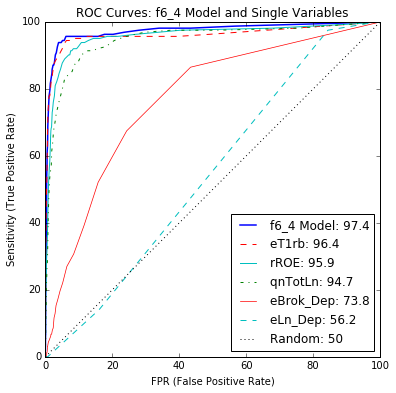

In [66]:
## Code to resize chart frame !!!!!!
#f6auc['aucs'] = f6auc.apply(lambda x:str(np.round(x['auc']*100,1)),axis=1)
dauc= dict(zip(f6auc['modvar'],f6auc['aucs']))

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1, plSize[1]*1.5) )  ## double width, single height
plt.plot(f6roc['f6_4rr_FPR']*100,f6roc['f6_4rr_sens']*100,c='b',lw=1.5,label=('f6_4 Model: '+dauc['f6_4rr']))
#plt.plot(f6roc['f6_1_FPR'],f6roc['f6_1_sens'],c='b',ls='--',label='f6_1: '+dauc['f6_1'])
plt.plot(f6roc['f6_eT1rb_FPR']*100,f6roc['f6_eT1rb_sens']*100,c='r',ls='--',label='eT1rb: '+dauc['f6_eT1rb'])
plt.plot(f6roc['f6_rROE_FPR']*100,f6roc['f6_rROE_sens']*100,c='c',ls='-',label='rROE: '+dauc['f6_rROE'])
plt.plot(f6roc['f6_qnTotLn_FPR']*100,f6roc['f6_qnTotLn_sens']*100,c='g',ls='-.',label='qnTotLn: '+dauc['f6_qnTotLn'])
#plt.plot(f6roc['f6_rROE_FPR'],f6roc['f6_rROE_sens'],c='c',label='rROE: '+dauc['f6_rROE'])
plt.plot(f6roc['f6_eBrok_Dep_FPR']*100,f6roc['f6_eBrok_Dep_sens']*100,c='r',lw=.7,label='eBrok_Dep: '+dauc['f6_eBrok_Dep'])
plt.plot(f6roc['f6_eLn_Dep_FPR']*100,f6roc['f6_eLn_Dep_sens']*100,c='c',ls='--',label='eLn_Dep: '+dauc['f6_eLn_Dep'])
plt.plot([0,100],[0,100],ls=':',c='k',label='Random: 50')
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(loc=0)
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xlabel('FPR (False Positive Rate)')
plt.title('ROC Curves: f6_4 Model and Single Variables')
plt.savefig('ROC_f6_roe0mm2_20091231exact.png', dpi=300, bbox_inches='tight')
plt.show()

In [67]:
#f2roc:
for i in np.arange(len(f2lst)):
#for i in np.arange(2):
  v = f2lst[i]
  y = roc(dffg, 'f2', v, ctlst)
  if i == 0:
    f2roc = y[['cut','sens','FPR']]
    f2roc.rename(columns={'FPR':v+'_FPR','sens':v+'_sens'},inplace=True)
  else:
    f2roc = f2roc.merge(y[['cut','sens','FPR']],how='left',on='cut')
    f2roc.rename(columns={'FPR':v+'_FPR','sens':v+'_sens'},inplace=True)

f2roc.to_csv("f2rocpts_roe0mm2_20091231exact.csv")
f2roc.head()    

cut  f2_0rr_sens  f2_0rr_FPR  f2_1rr_sens  f2_1rr_FPR  f2_lnTotAst_sens  \
0  0.000     1.000000    1.000000     1.000000    1.000000          1.000000   
1  0.001     0.967742    0.137469     0.967742    0.147667          0.822581   
2  0.002     0.967742    0.085499     0.967742    0.091925          0.274194   
3  0.003     0.967742    0.069153     0.967742    0.073903          0.112903   
4  0.004     0.967742    0.058955     0.967742    0.061051          0.048387   

   f2_lnTotAst_FPR  f2_rROE_sens  f2_rROE_FPR  f2_rROA_sens  f2_rROA_FPR  \
0         1.000000      1.000000     1.000000      1.000000     1.000000   
1         0.680358      0.967742     0.184828      0.983871     0.728695   
2         0.143476      0.951613     0.099749      0.951613     0.129925   
3         0.046661      0.951613     0.074183      0.854839     0.063286   
4         0.024867      0.951613     0.061609      0.741935     0.038698   

   f2_eT1rb_sens  f2_eT1rb_FPR  f2_qnTotLn_sens  f2_qnTotLn_FPR  \
0       1.000000      1.000000         1.000000        1.000000   
1       0.967742      0.142498         0.967742        0.716820   
2       0.967742      0.078933         0.951613        0.153535   
3       0.967742      0.054764         0.887097        0.075859   
4       0.967742      0.047220         0.822581        0.049315   

   f2_eBrok_Dep_sens  f2_eBrok_Dep_FPR  f2_eLn_Dep_sens  f2_eLn_Dep_FPR  
0           1.000000          1.000000              1.0        1.000000  
1           0.838710          0.420229              1.0        1.000000  
2           0.274194          0.081308              0.0        0.001257  
3           0.177419          0.034786              0.0        0.000419  
4           0.096774          0.021095              0.0        0.000140

In [68]:
f2roc.columns

Index([u'cut', u'f2_0rr_sens', u'f2_0rr_FPR', u'f2_1rr_sens', u'f2_1rr_FPR',
       u'f2_lnTotAst_sens', u'f2_lnTotAst_FPR', u'f2_rROE_sens',
       u'f2_rROE_FPR', u'f2_rROA_sens', u'f2_rROA_FPR', u'f2_eT1rb_sens',
       u'f2_eT1rb_FPR', u'f2_qnTotLn_sens', u'f2_qnTotLn_FPR',
       u'f2_eBrok_Dep_sens', u'f2_eBrok_Dep_FPR', u'f2_eLn_Dep_sens',
       u'f2_eLn_Dep_FPR'],
      dtype='object')

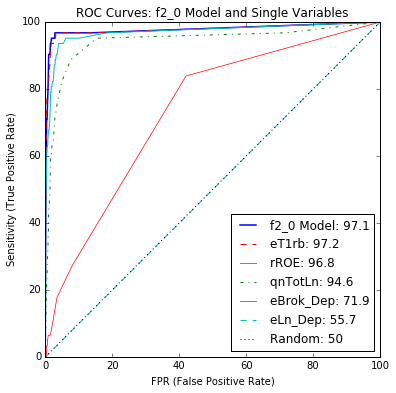

In [69]:
## Code to resize chart frame !!!!!!
#f2auc['aucs'] = f2auc.apply(lambda x:str(np.round(x['auc']*100,1)),axis=1)
dauc= dict(zip(f2auc['modvar'],f2auc['aucs']))

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1, plSize[1]*1.5) )  ## double width, single height
plt.plot(f2roc['f2_0rr_FPR']*100,f2roc['f2_0rr_sens']*100,c='b',lw=1.5,label=('f2_0 Model: '+dauc['f2_0rr']))
#plt.plot(f2roc['f2_1_FPR'],f2roc['f2_1_sens'],c='b',ls='--',label='f2_1: '+dauc['f2_1'])
plt.plot(f2roc['f2_eT1rb_FPR']*100,f2roc['f2_eT1rb_sens']*100,c='r',ls='--',label='eT1rb: '+dauc['f2_eT1rb'])
plt.plot(f2roc['f2_rROE_FPR']*100,f2roc['f2_rROE_sens']*100,c='c',ls='-',label='rROE: '+dauc['f2_rROE'])
plt.plot(f2roc['f2_qnTotLn_FPR']*100,f2roc['f2_qnTotLn_sens']*100,c='g',ls='-.',label='qnTotLn: '+dauc['f2_qnTotLn'])
#plt.plot(f2roc['f2_rROE_FPR'],f2roc['f2_rROE_sens'],c='c',label='rROE: '+dauc['f2_rROE'])
plt.plot(f2roc['f2_eBrok_Dep_FPR']*100,f2roc['f2_eBrok_Dep_sens']*100,c='r',lw=.7,label='eBrok_Dep: '+dauc['f2_eBrok_Dep'])
plt.plot(f2roc['f2_eLn_Dep_FPR']*100,f2roc['f2_eLn_Dep_sens']*100,c='c',ls='--',label='eLn_Dep: '+dauc['f2_eLn_Dep'])
plt.plot([0,100],[0,100],ls=':',c='k',label='Random: 50')
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(loc=0)
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xlabel('FPR (False Positive Rate)')
plt.title('ROC Curves: f2_0 Model and Single Variables')
plt.savefig('ROC_f2_roe0mm2_20091231exact.png', dpi=300, bbox_inches='tight')
plt.show()

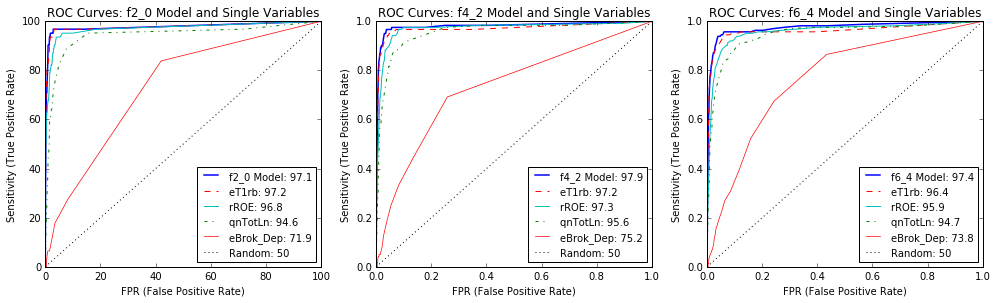

In [70]:
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2.8, plSize[1]*1.1) )  ## double width, single height

plt.subplot(1, 3, 1)
dauc= dict(zip(f2auc['modvar'],f2auc['aucs']))

params = plt.gcf()
plt.plot(f2roc['f2_0rr_FPR']*100,f2roc['f2_0rr_sens']*100,c='b',lw=1.5,label=('f2_0 Model: '+dauc['f2_0rr']))
#plt.plot(f2roc['f2_1_FPR'],f2roc['f2_1_sens'],c='b',ls='--',label='f2_1: '+dauc['f2_1'])
plt.plot(f2roc['f2_eT1rb_FPR']*100,f2roc['f2_eT1rb_sens']*100,c='r',ls='--',label='eT1rb: '+dauc['f2_eT1rb'])
plt.plot(f2roc['f2_rROE_FPR']*100,f2roc['f2_rROE_sens']*100,c='c',ls='-',label='rROE: '+dauc['f2_rROE'])
plt.plot(f2roc['f2_qnTotLn_FPR']*100,f2roc['f2_qnTotLn_sens']*100,c='g',ls='-.',label='qnTotLn: '+dauc['f2_qnTotLn'])
#plt.plot(f2roc['f2_rROE_FPR'],f2roc['f2_rROE_sens'],c='c',label='rROE: '+dauc['f2_rROE'])
plt.plot(f2roc['f2_eBrok_Dep_FPR']*100,f2roc['f2_eBrok_Dep_sens']*100,c='r',lw=.7,label='eBrok_Dep: '+dauc['f2_eBrok_Dep'])
#plt.plot(f2roc['f2_eLn_Dep_FPR'],f2roc['f2_eLn_Dep_sens'],c='c',ls='--',label='eLn_Dep: '+dauc['f2_eLn_Dep'])
plt.plot([0,100],[0,100],ls=':',c='k',label='Random: 50')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xlabel('FPR (False Positive Rate)')
plt.legend(loc=0, fontsize=10)
plt.title('ROC Curves: f2_0 Model and Single Variables')

plt.subplot(1, 3, 2)
dauc= dict(zip(f4auc['modvar'],f4auc['aucs']))

params = plt.gcf()
plt.plot(f4roc['f4_2rr_FPR'],f4roc['f4_2rr_sens'],c='b',lw=1.5,label='f4_2 Model: '+dauc['f4_2rr'])
#plt.plot(f4roc['f4_3rr_FPR'],f4roc['f4_3rr_sens'],c='b',ls='--',label='f4 Model2: '+dauc['f4_3rr'])
plt.plot(f4roc['f4_eT1rb_FPR'],f4roc['f4_eT1rb_sens'],c='r',ls='--',label='eT1rb: '+dauc['f4_eT1rb'])
#plt.plot(f4roc['f4_rROA_FPR'],f4roc['f4_rROA_sens'],c='c',ls='--',label='rROA: '+dauc['f4_rROA'])
plt.plot(f4roc['f4_rROE_FPR'],f4roc['f4_rROE_sens'],c='c',label='rROE: '+dauc['f4_rROE'])
plt.plot(f4roc['f4_qnTotLn_FPR'],f4roc['f4_qnTotLn_sens'],c='g',ls='-.',label='qnTotLn: '+dauc['f4_qnTotLn'])
plt.plot(f4roc['f4_eBrok_Dep_FPR'],f4roc['f4_eBrok_Dep_sens'],c='r',lw=.7,label='eBrok_Dep: '+dauc['f4_eBrok_Dep'])
#plt.plot(f4roc['f4_eLn_Dep_FPR'],f4roc['f4_eLn_Dep_sens'],c='c',ls='--',label='eLn_Dep: '+dauc['f4_eLn_Dep'])
#plt.plot(f4roc['f4_aFF_TA_FPR'],f4roc['f4_aFF_TA_sens'],c='g',ls='--',label='aFF_TA: '+dauc['f4_aFF_TA'])
plt.plot([0,1],[0,1],ls=':',c='k',label='Random: 50')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xlabel('FPR (False Positive Rate)')
plt.legend(loc=4,fontsize=10)
plt.title('ROC Curves: f4_2 Model and Single Variables')

plt.subplot(1, 3, 3)
dauc= dict(zip(f6auc['modvar'],f6auc['aucs']))

params = plt.gcf()
plt.plot(f6roc['f6_4rr_FPR'],f6roc['f6_4rr_sens'],c='b',lw=1.5,label=('f6_4 Model: '+dauc['f6_4rr']))
#plt.plot(f6roc['f6_1_FPR'],f6roc['f6_1_sens'],c='b',ls='--',label='f6_1: '+dauc['f6_1'])
plt.plot(f6roc['f6_eT1rb_FPR'],f6roc['f6_eT1rb_sens'],c='r',ls='--',label='eT1rb: '+dauc['f6_eT1rb'])
plt.plot(f6roc['f6_rROE_FPR'],f6roc['f6_rROE_sens'],c='c',ls='-',label='rROE: '+dauc['f6_rROE'])
plt.plot(f6roc['f6_qnTotLn_FPR'],f6roc['f6_qnTotLn_sens'],c='g',ls='-.',label='qnTotLn: '+dauc['f6_qnTotLn'])
#plt.plot(f6roc['f6_rROE_FPR'],f6roc['f6_rROE_sens'],c='c',label='rROE: '+dauc['f6_rROE'])
plt.plot(f6roc['f6_eBrok_Dep_FPR'],f6roc['f6_eBrok_Dep_sens'],c='r',lw=.7,label='eBrok_Dep: '+dauc['f6_eBrok_Dep'])
#plt.plot(f6roc['f6_eLn_Dep_FPR'],f6roc['f6_eLn_Dep_sens'],c='c',ls='--',label='eLn_Dep: '+dauc['f6_eLn_Dep'])
plt.plot([0,1],[0,1],ls=':',c='k',label='Random: 50')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xlabel('FPR (False Positive Rate)')
plt.legend(loc=4, fontsize=10)
plt.title('ROC Curves: f6_4 Model and Single Variables')

plt.savefig('ROC_f246_roe0mm2_20091231exact.png', dpi=400, bbox_inches='tight')
plt.show()

In [71]:
## identify optimal cut-off point

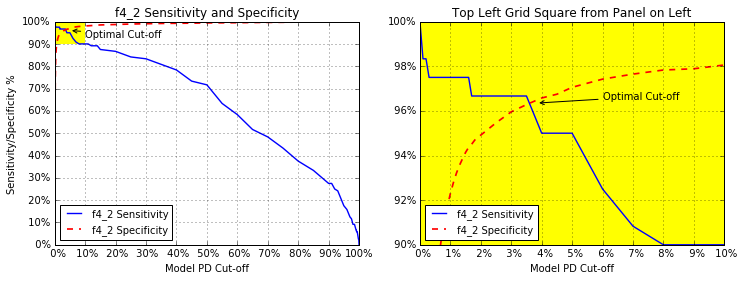

In [72]:
from matplotlib.patches import Rectangle

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*1) )  ## double width, single height

plt.subplot(1, 2, 1)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow",lw=0))
plt.plot(f4roc['cut'],f4roc['f4_2rr_sens'],'b-',lw=1.4,label='f4_2 Sensitivity')
plt.plot(f4roc['cut'],(1-f4roc['f4_2rr_FPR']),'r--',lw=1.7,label='f4_2 Specificity')
plt.ylim([0,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(0,1.01,.1)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,1])
xtix = np.arange(.0,1.01,.1)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=3,fontsize=10)
plt.annotate('Optimal Cut-off', xy=(.05,.96), xytext=(.1, .93),
            arrowprops=dict(arrowstyle = '->'))

plt.title('f4_2 Sensitivity and Specificity')
plt.grid('on')


plt.subplot(1, 2, 2)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow"))
plt.plot(f4roc['cut'],f4roc['f4_2rr_sens'],'b-',lw=1.4,label='f4_2 Sensitivity')
plt.plot(f4roc['cut'],(1-f4roc['f4_2rr_FPR']),'r--',lw=1.7,label='f4_2 Specificity')
plt.ylim([.9,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(.9,1.01,.02)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
#plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,.1])
xtix = np.arange(.0,.101,.01)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=3, fontsize=10)

plt.annotate('Optimal Cut-off', xy=(.0385,.9635), xytext=(.06, .965),
            arrowprops=dict(arrowstyle = '->'))

plt.title('Top Left Grid Square from Panel on Left')
plt.grid('on')
plt.savefig('SensSpecOptCut_f4_2_roe0mm2_20091231exact.png', dpi=400, bbox_inches='tight')
plt.show()

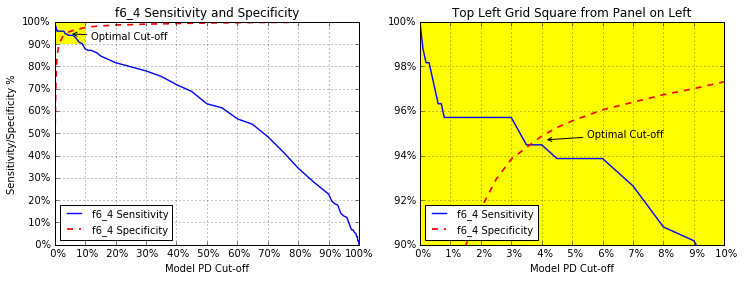

In [73]:
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*1) )  ## double width, single height

plt.subplot(1, 2, 1)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow",lw=0))
plt.plot(f6roc['cut'],f6roc['f6_4rr_sens'],'b-',lw=1.4,label='f6_4 Sensitivity')
plt.plot(f6roc['cut'],(1-f6roc['f6_4rr_FPR']),'r--',lw=1.7,label='f6_4 Specificity')
plt.ylim([0,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(0,1.01,.1)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,1])
xtix = np.arange(.0,1.01,.1)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=3,fontsize=10)
plt.annotate('Optimal Cut-off', xy=(.05,.945), xytext=(.12, .92),
            arrowprops=dict(arrowstyle = '->'))

plt.title('f6_4 Sensitivity and Specificity')
plt.grid('on')


plt.subplot(1, 2, 2)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow"))
plt.plot(f6roc['cut'],f6roc['f6_4rr_sens'],'b-',lw=1.4,label='f6_4 Sensitivity')
plt.plot(f6roc['cut'],(1-f6roc['f6_4rr_FPR']),'r--',lw=1.7,label='f6_4 Specificity')
plt.ylim([.9,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(.9,1.01,.02)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
#plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,.1])
xtix = np.arange(.0,.101,.01)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=3,fontsize=10)

plt.annotate('Optimal Cut-off', xy=(.041,.947), xytext=(.055, .948),
            arrowprops=dict(arrowstyle = '->'))

plt.title('Top Left Grid Square from Panel on Left')
plt.grid('on')
plt.savefig('SensSpecOptCut_f6_4_roe0mm2_20091231exact.png', dpi=400, bbox_inches='tight')
plt.show()

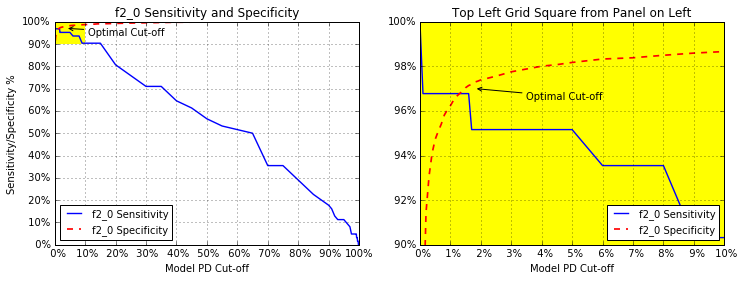

In [74]:
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*1) )  ## double width, single height

plt.subplot(1, 2, 1)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow",lw=0))
plt.plot(f2roc['cut'],f2roc['f2_0rr_sens'],'b-',lw=1.4,label='f2_0 Sensitivity')
plt.plot(f2roc['cut'],(1-f2roc['f2_0rr_FPR']),'r--',lw=1.7,label='f2_0 Specificity')
plt.ylim([0,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(0,1.01,.1)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,1])
xtix = np.arange(.0,1.01,.1)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=3, fontsize=10)
plt.annotate('Optimal Cut-off', xy=(.037,.97), xytext=(.11, .94),
            arrowprops=dict(arrowstyle = '->'))

plt.title('f2_0 Sensitivity and Specificity')
plt.grid('on')


plt.subplot(1, 2, 2)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow"))
plt.plot(f2roc['cut'],f2roc['f2_0rr_sens'],'b-',lw=1.4,label='f2_0 Sensitivity')
plt.plot(f2roc['cut'],(1-f2roc['f2_0rr_FPR']),'r--',lw=1.7,label='f2_0 Specificity')
plt.ylim([.9,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(.9,1.01,.02)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
#plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,.1])
xtix = np.arange(.0,.101,.01)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=4,fontsize=10)

plt.annotate('Optimal Cut-off', xy=(.018,.97), xytext=(.035, .965),
            arrowprops=dict(arrowstyle = '->'))

plt.title('Top Left Grid Square from Panel on Left')
plt.grid('on')

plt.savefig('SensSpecOptCut_f2_0_roe0mm2_20091231exact.png', dpi=400, bbox_inches='tight')
plt.show()


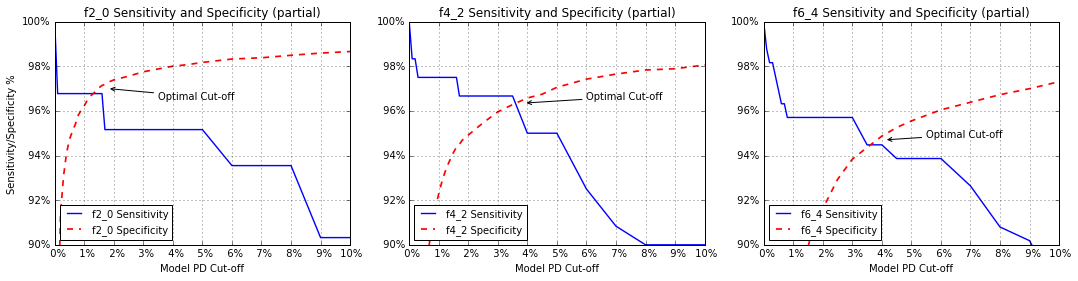

In [75]:
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*3, plSize[1]*1) )  ## double width, single height

plt.subplot(1, 3, 1)
plt.plot(f2roc['cut'],f2roc['f2_0rr_sens'],'b-',lw=1.4,label='f2_0 Sensitivity')
plt.plot(f2roc['cut'],(1-f2roc['f2_0rr_FPR']),'r--',lw=1.7,label='f2_0 Specificity')
plt.ylim([.9,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(.9,1.01,.02)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
#plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,.1])
xtix = np.arange(.0,.101,.01)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.ylabel('Sensitivity/Specificity %')
plt.legend(loc=3,fontsize=10)

plt.annotate('Optimal Cut-off', xy=(.018,.97), xytext=(.035, .965),
            arrowprops=dict(arrowstyle = '->'))

plt.title('f2_0 Sensitivity and Specificity (partial)')
plt.grid('on')

plt.subplot(1, 3, 2)
plt.plot(f4roc['cut'],f4roc['f4_2rr_sens'],'b-',lw=1.4,label='f4_2 Sensitivity')
plt.plot(f4roc['cut'],(1-f4roc['f4_2rr_FPR']),'r--',lw=1.7,label='f4_2 Specificity')
plt.ylim([.9,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(.9,1.01,.02)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
#plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,.1])
xtix = np.arange(.0,.101,.01)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=3, fontsize=10)

plt.annotate('Optimal Cut-off', xy=(.039,.9635), xytext=(.06, .965),
            arrowprops=dict(arrowstyle = '->'))

plt.title('f4_2 Sensitivity and Specificity (partial)')
plt.grid('on')

plt.subplot(1, 3, 3)
plt.plot(f6roc['cut'],f6roc['f6_4rr_sens'],'b-',lw=1.4,label='f6_4 Sensitivity')
plt.plot(f6roc['cut'],(1-f6roc['f6_4rr_FPR']),'r--',lw=1.7,label='f6_4 Specificity')
plt.ylim([.9,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(.9,1.01,.02)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
#plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,.1])
xtix = np.arange(.0,.101,.01)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=3,fontsize=10)

plt.annotate('Optimal Cut-off', xy=(.041,.947), xytext=(.055, .948),
            arrowprops=dict(arrowstyle = '->'))

plt.title('f6_4 Sensitivity and Specificity (partial)')
plt.grid('on')

plt.savefig('SensSpecOptCut_f246partial_roe0mm2_20091231exact.png', dpi=400, bbox_inches='tight')
plt.show()

In [76]:
dffg.tail(2)

AsOf  f2  f4  f6  f8          f2_0          f2_1          f4_2  \
404544 2009-12-31   0   0   0   0  7.338898e-10  1.088939e-09  2.190482e-08   
404568 2009-12-31   0   0   0   0  6.212909e-07  8.110640e-07  6.146088e-06   

                f4_3          f6_4    ...      f6_qnTotLn  f2_eBrok_Dep  \
404544  1.884868e-08  7.105124e-07    ...        0.002709       0.00098   
404568  2.069154e-06  1.905622e-05    ...        0.002709       0.00098   

        f4_eBrok_Dep  f6_eBrok_Dep  f2_eLn_Dep  f4_eLn_Dep  f6_eLn_Dep  \
404544      0.002449      0.003966    0.001265    0.003141    0.005042   
404568      0.002449      0.003966    0.001300    0.003243    0.005229   

        f2_aFF_TA  f4_aFF_TA  f6_aFF_TA  
404544   0.001627   0.003824   0.005598  
404568   0.001521   0.003682   0.005608  

[2 rows x 41 columns]

In [77]:
## dffg: check 96% percentile levels:
dffg.columns

Index([u'AsOf', u'f2', u'f4', u'f6', u'f8', u'f2_0', u'f2_1', u'f4_2', u'f4_3',
       u'f6_4', u'f6_5', u'f2_0rr', u'f2_1rr', u'f4_2rr', u'f4_3rr', u'f6_4rr',
       u'f6_5rr', u'f2_lnTotAst', u'f4_lnTotAst', u'f6_lnTotAst', u'f2_rROE',
       u'f4_rROE', u'f6_rROE', u'f2_rROA', u'f4_rROA', u'f6_rROA', u'f2_eT1rb',
       u'f4_eT1rb', u'f6_eT1rb', u'f2_qnTotLn', u'f4_qnTotLn', u'f6_qnTotLn',
       u'f2_eBrok_Dep', u'f4_eBrok_Dep', u'f6_eBrok_Dep', u'f2_eLn_Dep',
       u'f4_eLn_Dep', u'f6_eLn_Dep', u'f2_aFF_TA', u'f4_aFF_TA', u'f6_aFF_TA'],
      dtype='object')

In [78]:
dffg[['f2_0','f4_2','f6_4']].quantile(.96) # distorted by mixing TN, FPs

f2_0    0.013180
f4_2    0.063968
f6_4    0.132991
dtype: float64

In [79]:
dffg[['f2_1','f4_3','f6_5']].quantile(.96) # distorted by mixing TN, FPs

f2_1    0.013324
f4_3    0.064756
f6_5    0.127752
dtype: float64

In [80]:
dffg[dffg['f4']==0][['f4_2','f4_3']].quantile(.96).values, dffg[dffg['f4']==1][['f4_2','f4_3']].quantile(.04).values

(array([ 0.03071293,  0.03367707]), array([ 0.0379706 ,  0.04093801]))

In [81]:
dffg[dffg['f2']==0][['f2_0','f2_1']].quantile(.96).values, dffg[dffg['f2']==1][['f2_0','f2_1']].quantile(.04).values

(array([ 0.00876518,  0.00888477]), array([ 0.03434222,  0.03770144]))

In [82]:
dffg[dffg['f6']==0][['f6_4','f6_5']].quantile(.96).values, dffg[dffg['f6']==1][['f6_4','f6_5']].quantile(.04).values

(array([ 0.05857401,  0.05392961]), array([ 0.01840818,  0.01600897]))

In [83]:
## conclusion:  always use 96%ile of no-fails (large group) if possible... worst4% is a very rough approx that is OK to model!